### ДЗ5: метод опорных векторов.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("D:\\ds\\train.csv", low_memory=False)

Целевой признак `Credit_Score`

Выясните, клиенты с каким значением признака `Payment_Behaviour` более склонны к просрочкам по кредиту `(Credit_Score=Poor)`?

In [3]:
poor_credit = train[train['Credit_Score'] == 'Poor']
poor_credit['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      9125
High_spent_Medium_value_payments    4439
Low_spent_Medium_value_payments     4211
High_spent_Small_value_payments     3088
High_spent_Large_value_payments     2979
Low_spent_Large_value_payments      2931
!@9#%8                              2225
Name: count, dtype: int64

Для выполнения задания вы можете самостоятельно создать Python-ноутбук, а в LMS прикладывать лишь требуемые результаты.

Продолжайте работать с датасетом для предсказания кредитного дефолта.

В данных есть заведомо неинформативные столбцы, поэтому их нужно удалить.

Укажите в ответе названия этих столбцов через пробел в одной строке.

Формат ответа:  Признак1 Признак2
В ответе может быть любое количество признаков.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

`ID Customer_ID Name SSN` 

Удалите явные пропуски в данных. Изучите признаки в датасете, убедитесь, что типы данных соответствуют значениям в признаке.

Если есть несостыковки по типам данных, то удалите те строки, где тип значения в признаке не соответствует типу признака (для удобства можете эти значения переводить в NaN).

Оставьте в выборке только численные признаки.

Укажите в ответе, сколько осталось объектов в выборке.

In [5]:
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN']
train = train.drop(columns=columns_to_drop)
print(train.isna().sum())
train = train.dropna()

Month                           0
Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64


In [6]:
def get_uniques(dataframe):
    columns = dataframe.columns
    uniques = [dataframe[col].dropna().unique().tolist() for col in columns]
    data_types = [dataframe[col].dtype for col in columns]
    result_df = pd.DataFrame(
        {'Столбцы': columns,
         'Уникальные значения': uniques, 
         'Тип данных': data_types})
    return result_df

In [7]:
get_uniques(train)

,Столбцы,Уникальные значения,Тип данных
0,Month,"[January, July, February, March, May, June, Au...",object
1,Age,"[23, 28_, 28, 34, 54, 55, 33, 30, 24, 24_, 44,...",object
2,Occupation,"[Scientist, _______, Teacher, Engineer, Entrep...",object
3,Annual_Income,"[19114.12, 34847.84, 34847.84_, 143162.64, 306...",object
4,Monthly_Inhand_Salary,"[1824.8433333333328, 3037.986666666666, 12187....",float64
5,Num_Bank_Accounts,"[3, 2, 1, 0, 8, 5, 6, 7, 9, 10, 4, 67, 528, 16...",int64
6,Num_Credit_Card,"[4, 1385, 5, 1, 7, 6, 1029, 8, 1381, 3, 9, 132...",int64
7,Interest_Rate,"[3, 6, 8, 4, 15, 7, 12, 20, 1, 433, 14, 32, 17...",int64
8,Num_of_Loan,"[4, 1, 3, 967, -100, 2, 3_, 7, 5, 5_, 6, 8, 2_...",object
9,Type_of_Loan,"[Auto Loan, Credit-Builder Loan, Personal Loan...",object


In [8]:
numeric_columns = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                   'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
                   'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 
                   'Outstanding_Debt', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

for col in numeric_columns:
    train[col] = pd.to_numeric(train[col], errors='coerce')

le = LabelEncoder()

train['Credit_Score'] = le.fit_transform(train['Credit_Score'])
train = train.select_dtypes(include=[np.number])
train = train.dropna()

print(f"Осталось {len(train)} объектов в выборке.")

Осталось 44568 объектов в выборке.


In [10]:
get_uniques(train)

,Столбцы,Уникальные значения,Тип данных
0,Age,"[23.0, 28.0, 34.0, 54.0, 55.0, 33.0, 30.0, 24....",float64
1,Annual_Income,"[19114.12, 34847.84, 143162.64, 30689.89, 1313...",float64
2,Monthly_Inhand_Salary,"[1824.8433333333328, 3037.986666666666, 12187....",float64
3,Num_Bank_Accounts,"[3, 2, 1, 0, 8, 5, 6, 7, 9, 10, 4, 67, 528, 16...",int64
4,Num_Credit_Card,"[4, 5, 1, 7, 6, 1029, 8, 1381, 3, 9, 1327, 10,...",int64
5,Interest_Rate,"[3, 6, 8, 4, 15, 7, 12, 20, 1, 14, 32, 17, 10,...",int64
6,Num_of_Loan,"[4.0, 1.0, 3.0, 967.0, -100.0, 2.0, 7.0, 5.0, ...",float64
7,Delay_from_due_date,"[3, 7, 5, 13, 10, 8, 0, 4, -1, 30, 34, 11, 2, ...",int64
8,Num_of_Delayed_Payment,"[7.0, 1.0, 0.0, 4.0, 8.0, 6.0, 5.0, 3.0, 9.0, ...",float64
9,Changed_Credit_Limit,"[11.27, 7.42, 6.42, 5.42, 7.1, 1.99, -3.01, 9....",float64


Сделайте разбиение на обучение и тест с соотношением 80/20, со стратификацией по целевому признаку и random_state=1.

Выполните обучение модели SVC с параметрами по умолчанию.

Выведите опорные векторы (для этого используйте атрибут .support_vectors_).

В ответе укажите количество векторов.

In [9]:
X = train.drop(columns=['Credit_Score'])  
y = train['Credit_Score'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [10]:
model = SVC(random_state=1)
model.fit(X_train, y_train)

support_vectors = model.support_vectors_
print(f"Количество опорных векторов: {len(support_vectors)}")

Количество опорных векторов: 31337


Чтобы модель быстрее обучалась возьмите выборку меньшей размерности - на тренировочной выборке оставьте 10000 случайных объектов, а на тесте - 2000.

Получайте индексы объектов через `np.random.choice` с `replace=False`, зафиксируйте случайность для трейна через `np.random.seed(1)`, а для теста - `np.random.seed(2)`.

Обучите еще раз модели SVC на параметрах по умолчанию, но перед этим сделайте масштабирование данных через стандартизацию, можете воспользоваться методом `make_pipeline`.

Сделайте предсказания моделью на тестовой выборке и посчитайте метрику `recall` для каждого класса. Для удобства можете воспользоваться функцией `classification_report`.

Укажите в ответе значения метрик, округлив их до второго знака после точки

In [11]:
np.random.seed(1)
train_sample = np.random.choice(X_train.index, size=10000, replace=False)

np.random.seed(2)
test_sample = np.random.choice(X_test.index, size=2000, replace=False)

X_train_sampled = X_train.loc[train_sample]
y_train_sampled = y_train.loc[train_sample]
X_test_sampled = X_test.loc[test_sample]
y_test_sampled = y_test.loc[test_sample]

model = make_pipeline(StandardScaler(), SVC(random_state=1))
model.fit(X_train_sampled, y_train_sampled)
y_pred = model.predict(X_test_sampled)

report = classification_report(
    y_test_sampled, 
    y_pred, 
    target_names=['Good', 'Poor', 'Standard'], 
    output_dict=True
)

good_recall = round(report['Good']['recall'], 2)
poor_recall = round(report['Poor']['recall'], 2)
standard_recall = round(report['Standard']['recall'], 2)

print(f"Класс Good: {good_recall}")
print(f"Класс Poor: {poor_recall}")
print(f"Класс Standard: {standard_recall}")

Класс Good: 0.02
Класс Poor: 0.5
Класс Standard: 0.85


У модели SVC изменяйте ядра: `['linear', 'rbf', 'poly']`, другие параметры оставьте по умолчанию.

Используйте масштабированные данные.

Укажите в ответе ядро, при котором получилась самая высокая метрика на тесте recall с макро усреднением

In [12]:
kernels = ['linear', 'rbf', 'poly']

np.random.seed(1)
train_sample = np.random.choice(X_train.index, size=10000, replace=False)

np.random.seed(2)
test_sample = np.random.choice(X_test.index, size=2000, replace=False)

X_train_sampled = X_train.loc[train_sample]
y_train_sampled = y_train.loc[train_sample]
X_test_sampled = X_test.loc[test_sample]
y_test_sampled = y_test.loc[test_sample]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test_sampled)


best_kernel = None
best_recall = 0

for kernel in kernels:
    model = SVC(kernel=kernel, random_state=1)
    model.fit(X_train_scaled, y_train_sampled)
    
    y_pred = model.predict(X_test_scaled)
    
    report = classification_report(
        y_test_sampled, 
        y_pred, 
        target_names=['Good', 'Poor', 'Standard'], 
        output_dict=True, 
        zero_division=0
    )
    
    macro_recall = report['macro avg']['recall']
    
    if macro_recall > best_recall:
        best_recall = macro_recall
        best_kernel = kernel

print(f"Лучшее ядро: {best_kernel}")
print(f"Макро усредненный recall: {best_recall:.2f}")


Лучшее ядро: rbf
Макро усредненный recall: 0.46


У модели SVC возьмите самое лучшее ядро с предыдущего задания, другие параметры оставьте по умолчанию.

Подберите самое лучшее значение параметра C из списка `[0.001, 0.01, 0.1, 1, 10, 100]`.

Используйте масштабированные данные.

Визуализируйте изменение метрики `recall_macro` на тренировочной и тестовой выборках от параметра C.
Укажите в ответе значение C, при котором получилась самая высокая метрика на тесте `recall` с макро усреднением.

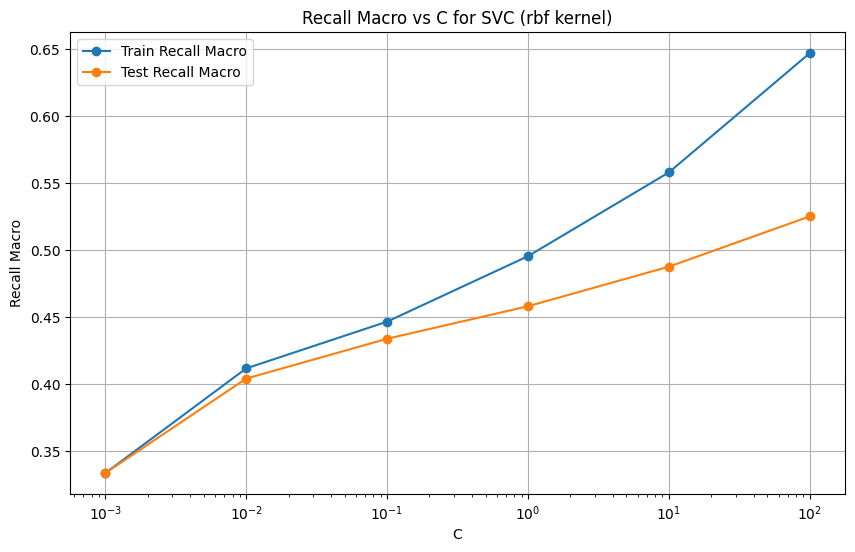

Лучшее значение C: 100
Макро усредненный recall на тесте: 0.53


In [13]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_recall = []
test_recall = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, random_state=1)
    model.fit(X_train_scaled, y_train_sampled)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    train_report = classification_report(
        y_train_sampled, 
        y_train_pred, 
        target_names=['Good', 'Poor', 'Standard'], 
        output_dict=True, 
        zero_division=0
    )
    test_report = classification_report(
        y_test_sampled, 
        y_test_pred, 
        target_names=['Good', 'Poor', 'Standard'], 
        output_dict=True, 
        zero_division=0
    )
    train_recall.append(train_report['macro avg']['recall'])
    test_recall.append(test_report['macro avg']['recall'])

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_recall, label='Train Recall Macro', marker='o')
plt.plot(C_values, test_recall, label='Test Recall Macro', marker='o')
plt.xscale('log') 
plt.xlabel('C')
plt.ylabel('Recall Macro')
plt.title('Recall Macro vs C for SVC (rbf kernel)')
plt.legend()
plt.grid()
plt.show()

best_C = C_values[np.argmax(test_recall)]
best_test_recall = max(test_recall)

print(f"Лучшее значение C: {best_C}")
print(f"Макро усредненный recall на тесте: {best_test_recall:.2f}")

Возьмите самые лучшие гиперпараметры модели с предыдущего задания, сделайте предсказания на тестовой выборке и посчитайте метрику `ROC-AUC`, параметр `multi_class` возьмите такой же (ovr и ovo), как и в модели SVC по умолчанию.

Для удобства можно перевести строковые целевые значения в порядковые числа через LabelEncoder.

Используйте масштабированные данные.

Обратите внимание, что по умолчанию модель SVC не умеет предсказывать вероятности.

В ответе укажите метрику `ROC-AUC` с округлением до второго знака после точки.

In [14]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sampled)
y_test_encoded = label_encoder.transform(y_test_sampled)

model = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel='rbf', 
        C=100, 
        probability=True, 
        random_state=1
    )
)
model.fit(X_train_scaled, y_train_encoded)
y_test_prob = model.predict_proba(X_test_scaled)
roc_auc_ovr = roc_auc_score(
    y_test_encoded, 
    y_test_prob, 
    multi_class='ovr', 
    average='macro'
)
roc_auc_ovo = roc_auc_score(
    y_test_encoded, 
    y_test_prob, 
    multi_class='ovo', 
    average='macro'
)
print(f"ROC-AUC для multi_class='ovr': {roc_auc_ovr:.2f}")
print(f"ROC-AUC для multi_class='ovo': {roc_auc_ovo:.2f}")

ROC-AUC для multi_class='ovr': 0.75
ROC-AUC для multi_class='ovo': 0.76


Давайте убедимся, что подобранные гиперпараметры модели точно самые лучшие, для этого сделайте:
- перебор ядер `['rbf', 'poly']` (линейное убрали)
- перебор значения C из списка `[0.001, 0.01, 0.1, 1, 10, 100]`
- другие параметры оставьте по умолчанию.

Используйте масштабированные данные.

Считайте качество модели по кросс-валидации на 3 фолда `(cross_val_score)` на метрике `recall` с макро усреднением только на тренировочной выборке.

Укажите в ответе лучшие гиперпараметры и метрику по кросс-валидации, округлив её до второго знака после точки

In [15]:
kernels = ['rbf', 'poly']
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

def get_best_hyperparameters(X_train, y_train):
    best_score = 0
    best_kernel = None
    best_C = None

    for kernel in kernels:
        for C in C_values:
            model = make_pipeline(
                StandardScaler(), 
                SVC(
                    kernel=kernel,
                    C=C, 
                    probability=True, 
                    random_state=1
                )
            )
            recall_scores = cross_val_score(
                model, 
                X_train, 
                y_train, 
                cv=3, 
                scoring='recall_macro'
            )
            avg_recall = np.mean(recall_scores)
            if avg_recall > best_score:
                best_score = avg_recall
                best_kernel = kernel
                best_C = C

    return best_kernel, best_C, best_score

best_kernel, best_C, best_recall = get_best_hyperparameters(X_train_scaled, y_train_encoded)

print(f"Лучшее ядро: {best_kernel}")
print(f"Лучшее значение C: {best_C}")
print(f"Лучший recall (по кросс-валидации): {best_recall:.2f}")

Лучшее ядро: rbf
Лучшее значение C: 100
Лучший recall (по кросс-валидации): 0.53
